In [1]:
# check kernel environment
import sys
print("Kernel: {}".format(sys.executable))

# Install missing packages
%pip install seaborn
%pip install fuzzywuzzy

# Core data analysis packages
import pandas as pd
import numpy as np

# For our EDA charts
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Compressed Sparse Row ("CSR") matrix
from scipy.sparse import csr_matrix 

# use K-Nearest Neighbors to find cosine distance amongst artists
from sklearn.neighbors import NearestNeighbors

# Install scikit-surprise for recommender system models and import surprise modules

# fuzzy string matching to allow for differing spelling of artist names
from fuzzywuzzy import fuzz, process

# set output to three decimals
pd.set_option('display.float_format',lambda x: '%.2f' %x)

# set seed for reproducibility of random number initializations
seed = np.random.RandomState(seed=42)

Kernel: C:\Users\Svanz\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Svanz\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\Svanz\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
C:\Users\Svanz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# The Dataset

Importing data

In [2]:
plays   = pd.read_csv('Data/user_artists.dat', sep='\t')
artists = pd.read_csv('Data/artists.dat', sep='\t', usecols=['id','name'])
tags    = pd.read_csv('Data/tags.dat', sep='\t', encoding='latin-1')
uta     = pd.read_csv('Data/user_taggedartists.dat', sep='\t')
utat    = pd.read_csv('Data/user_taggedartists-timestamps.dat', sep='\t')
friends = pd.read_csv('Data/user_friends.dat', sep='\t')

In [3]:
# Function to print various statistics on the dataset
def print_info(df_list, df_name):

    assert len(df_list) == len(df_name)

    for i in range(len(df_list)):
        print(df_name[i],'\n')
        print("Shape: {}\n".format(df_list[i].shape))
        print("Info:")
        print(df_list[i].info(),'\n')
        print("Unique:\n{}\n".format(df_list[i].nunique()))     
        
        # This returns True if no duplicates are dropped (ie duplicates do not exist)
        print("No duplicates: {}\n".format(len(df_list[i])==len(df_list[i].drop_duplicates())))

In [4]:
df_list = [plays, artists, tags, uta, utat, friends]
df_name = ['***Plays***', 
           '***Artists***', 
           '***Tags***', 
           '***User Tagged Artists***',
           '***User Tagged Artists Timestamps***', 
           '***User Friends***']
print_info(df_list, df_name)

***Plays*** 

Shape: (92834, 3)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92834 entries, 0 to 92833
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    92834 non-null  int64
 1   artistID  92834 non-null  int64
 2   weight    92834 non-null  int64
dtypes: int64(3)
memory usage: 2.1 MB
None 

Unique:
userID       1892
artistID    17632
weight       5436
dtype: int64

No duplicates: True

***Artists*** 

Shape: (17632, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17632 entries, 0 to 17631
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17632 non-null  int64 
 1   name    17632 non-null  object
dtypes: int64(1), object(1)
memory usage: 275.6+ KB
None 

Unique:
id      17632
name    17632
dtype: int64

No duplicates: True

***Tags*** 

Shape: (11946, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 

# Exploratory Data Analysis (EDA)

In [71]:
print("**************** Plays DataFrames ****************")
display(plays.describe())
display(plays.head())
    
print("**************** Artists DataFrames ****************")
display(artists.describe())
display(artists.head())

**************** Plays DataFrames ****************


,userID,artistID,weight
count,92834.00,92834.00,92834.00
mean,1037.01,3331.12,745.24
std,610.87,4383.59,3751.32
min,2.00,1.00,1.00
25%,502.00,436.00,107.00
50%,1029.00,1246.00,260.00
75%,1568.00,4350.00,614.00
max,2100.00,18745.00,352698.00


,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


**************** Artists DataFrames ****************


,id
count,17632.00
mean,9156.64
std,5392.52
min,1.00
25%,4501.75
50%,9048.50
75%,13769.25
max,18745.00


,id,name
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte


So we have artist ID and name along with users and plays in a single file, we will merge our two primary data files into one:

In [5]:
ap = pd.merge(artists, plays, how='inner', left_on='id', right_on='artistID')
ap = ap.rename(columns={"weight":"userArtistPlays"})
ap

,id,name,userID,artistID,userArtistPlays
0,1,MALICE MIZER,34,1,212
1,1,MALICE MIZER,274,1,483
2,1,MALICE MIZER,785,1,76
3,2,Diary of Dreams,135,2,1021
4,2,Diary of Dreams,257,2,152
...,...,...,...,...,...
92829,18741,Diamanda Galás,454,18741,301
92830,18742,Aya RL,454,18742,294
92831,18743,Coptic Rain,454,18743,287
92832,18744,Oz Alchemist,454,18744,286


Let's rank and artist based on the values in the "ap" dataset

In [6]:
artist_rank = (ap.groupby(['name'])
               .agg({'userID':'count','userArtistPlays':'sum'})
               .rename(columns={"userID":"totalUniqueUsers","userArtistPlays":"totalArtistPlays"})
               .sort_values(['totalArtistPlays'],
                            ascending=False))
artist_rank['avgUserPlays'] = artist_rank['totalArtistPlays']/artist_rank['totalUniqueUsers']

user_rank = (ap.groupby(['userID'])
             .agg({'name':'count','userArtistPlays':'sum'})
             .rename(columns={"name":"totalUniqueArtists","userArtistPlays":"totalUserPlays"})
             .sort_values(['totalUserPlays'],
                          ascending=False))

In [7]:
display(artist_rank.describe())
display(user_rank.describe())

,totalUniqueUsers,totalArtistPlays,avgUserPlays
count,17632.00,17632.00,17632.00
mean,5.27,3923.77,423.78
std,20.62,34099.34,785.38
min,1.00,1.00,1.00
25%,1.00,113.00,97.00
50%,1.00,350.00,246.00
75%,3.00,1234.25,496.88
max,611.00,2393140.00,35323.00


,totalUniqueArtists,totalUserPlays
count,1892.00,1892.00
mean,49.07,36566.58
std,5.85,48744.55
min,1.00,3.00
25%,50.00,9742.25
50%,50.00,21573.00
75%,50.00,42963.75
max,50.00,480039.00


In [8]:
display(artist_rank.head())
display(user_rank.head())

,totalUniqueUsers,totalArtistPlays,avgUserPlays
name,,,
Britney Spears,522,2393140,4584.56
Depeche Mode,282,1301308,4614.57
Lady Gaga,611,1291387,2113.56
Christina Aguilera,407,1058405,2600.50
Paramore,399,963449,2414.66


,totalUniqueArtists,totalUserPlays
userID,,
757,50,480039
2000,50,468409
1418,50,416349
1642,50,388251
1094,50,379125


For convenience we will join our artist and user data into a single table

In [9]:
ap2 = ap.join(artist_rank, on='name', how='inner')
ap3 = ap2.join(user_rank,on='userID',how='inner').sort_values(['userArtistPlays'],ascending=False)

# check there are no duplicate userID-artist name pairs
assert ap3[ap3.duplicated(['userID','name'])].empty

display(ap3.describe())
display(ap3.head())

,id,userID,artistID,userArtistPlays,totalUniqueUsers,totalArtistPlays,avgUserPlays,totalUniqueArtists,totalUserPlays
count,92834.00,92834.00,92834.00,92834.00,92834.00,92834.00,92834.00,92834.00,92834.00
mean,3331.12,1037.01,3331.12,745.24,86.02,111849.21,745.24,49.76,37074.17
std,4383.59,610.87,4383.59,3751.32,123.19,272120.34,756.30,2.45,48934.68
min,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,3.00
25%,436.00,502.00,436.00,107.00,5.00,2239.00,353.79,50.00,10143.00
50%,1246.00,1029.00,1246.00,260.00,31.00,17408.00,564.00,50.00,21843.00
75%,4350.00,1568.00,4350.00,614.00,111.00,80184.00,875.52,50.00,43897.00
max,18745.00,2100.00,18745.00,352698.00,611.00,2393140.00,35323.00,50.00,480039.00


,id,name,userID,artistID,userArtistPlays,totalUniqueUsers,totalArtistPlays,avgUserPlays,totalUniqueArtists,totalUserPlays
2800,72,Depeche Mode,1642,72,352698,282,1301308,4614.57,50,388251
35843,792,Thalía,2071,792,324663,26,350035,13462.88,50,338400
27302,511,U2,1094,511,320725,185,493024,2664.99,50,379125
8152,203,Blur,1905,203,257978,114,318221,2791.41,50,276295
26670,498,Paramore,1664,498,227829,399,963449,2414.66,50,251560


In [10]:
print_info([ap3[['userID','artistID']]],['***Artist Plays***'])

***Artist Plays*** 

Shape: (92834, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
Index: 92834 entries, 2800 to 63982
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    92834 non-null  int64
 1   artistID  92834 non-null  int64
dtypes: int64(2)
memory usage: 2.1 MB
None 

Unique:
userID       1892
artistID    17632
dtype: int64

No duplicates: True



# Visualizing Data Insights

In [13]:
def bar_chart_int(x,y,x_label,y_label,title,caption,total_val):
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 5)
    ax = sns.barplot(x=x[:20], y=y[:20], palette="PuRd")
    ax.set_xlabel(x_label,fontweight='bold')
    ax.set_ylabel(y_label,fontweight='bold')
    ax.set_title(title,fontweight='bold')
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x))))

    # our bar label placement
    for p in ax.patches:
        height = p.get_height()
        pct = 100*(height/total_val)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(pct),
                ha="center",verticalalignment='bottom',color='black') 

    # our caption statement
    ax.text(19, max(y[:20])*0.95, caption, style='italic',fontsize=12,horizontalalignment='right')

    plt.xticks(rotation=90)
    plt.show()

C:\Users\Svanz\AppData\Local\Temp\ipykernel_25984\4009831005.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x[:20], y=y[:20], palette="PuRd")


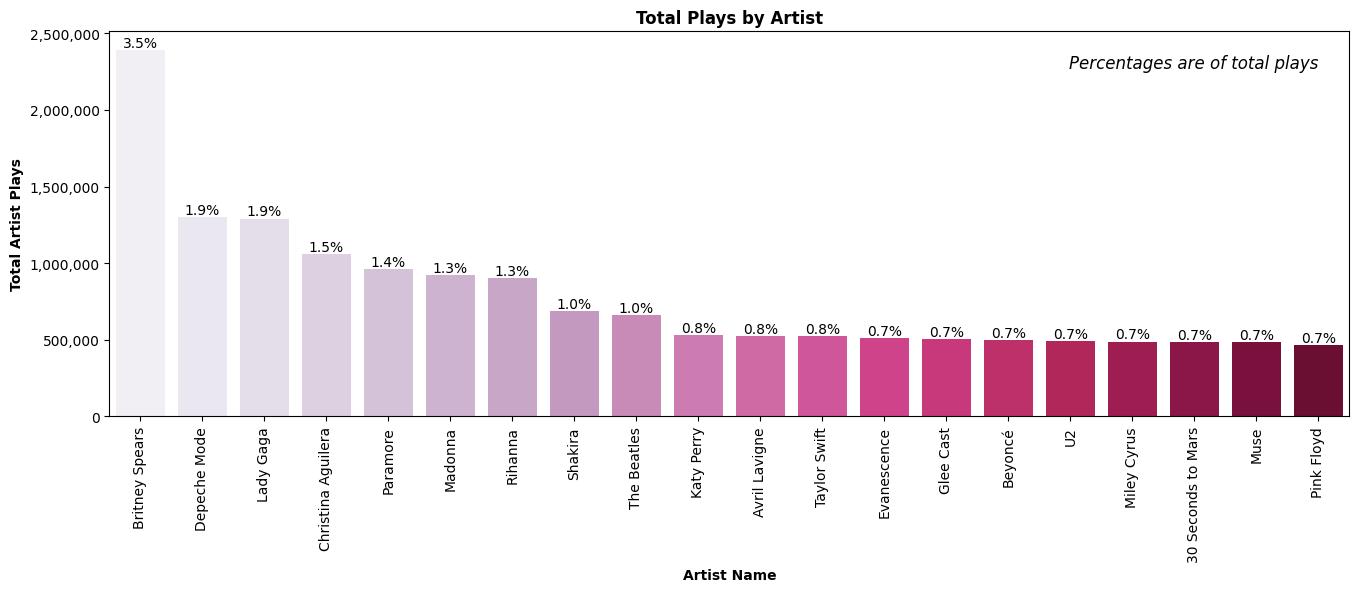

In [17]:
c1 = artist_rank
x = c1.index
y = c1.totalArtistPlays
x_label = 'Artist Name'
y_label = 'Total Artist Plays'
title = 'Total Plays by Artist'
caption = 'Percentages are of total plays'
total_val = c1.totalArtistPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

C:\Users\Svanz\AppData\Local\Temp\ipykernel_25984\4009831005.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x[:20], y=y[:20], palette="PuRd")


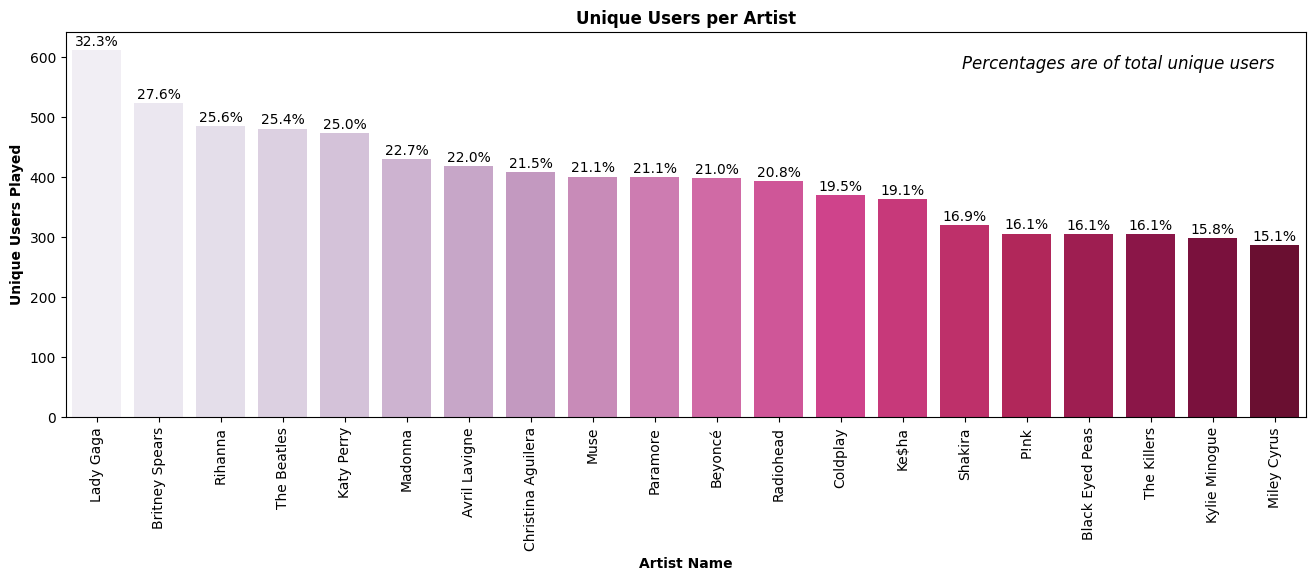

In [16]:
# Lady Gaga has been played by 32.3% of the users in the sample
c2 = artist_rank.sort_values(['totalUniqueUsers'],ascending=False)
x = c2.index
y = c2.totalUniqueUsers
x_label = 'Artist Name'
y_label = 'Unique Users Played'
title = 'Unique Users per Artist'
caption = 'Percentages are of total unique users'
total_val = ap3.userID.nunique()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

Compare both total artist plays and unique users metrics on a single chart

C:\Users\Svanz\AppData\Local\Temp\ipykernel_25984\2467585953.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(t,(x[i],y[i]))


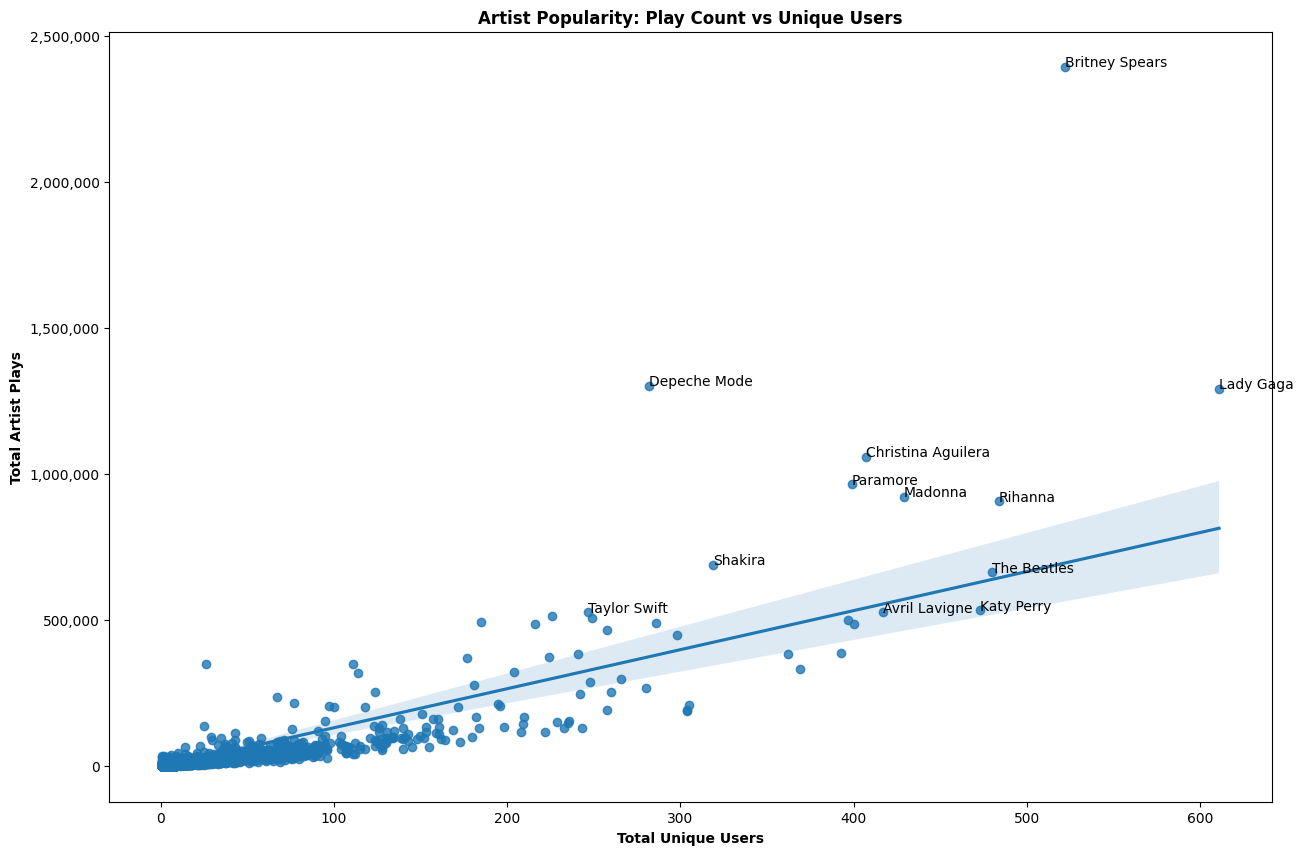

In [19]:
top_artists = artist_rank.sort_values(['totalArtistPlays'],ascending=False).index[:12]

x = artist_rank.totalUniqueUsers
y = artist_rank.totalArtistPlays
labels = artist_rank.index

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x=x,y=y)
ax.set_title('Artist Popularity: Play Count vs Unique Users',fontweight='bold')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))
ax.set_xlabel('Total Unique Users',fontweight='bold')
ax.set_ylabel('Total Artist Plays',fontweight='bold')

for i, t in enumerate(labels):
    if t in top_artists:
        ax.annotate(t,(x[i],y[i]))

# Item Similarity with K-Nearest Neighbors

In [23]:
def data_to_sparse(data,index,columns,values):
    pivot = data.pivot(index=index,columns=columns,values=values).fillna(0)
    sparse = csr_matrix(pivot.values)
    print(sparse.shape)
    return pivot,sparse

In [21]:
def fit_knn(sparse):
    knn = NearestNeighbors(metric='cosine')
    knn.fit(sparse)
    print(knn)
    return knn

In [24]:
pivot_ap3,sparse_ap3 = data_to_sparse(ap3,index='name',columns='userID',values='userArtistPlays')

(17632, 1892)


In [37]:
print(ap3['name'].unique())

['Depeche Mode' 'Thalía' 'U2' ... 'The Manhattan Transfer'
 'Willie Nelson & Ray Price' 'Haylie Duff']


In [53]:
knn = fit_knn(sparse_ap3)

NearestNeighbors(metric='cosine')


In [45]:
pivot_ap3.head()

userID,2,3,4,5,6,7,8,9,10,11,...,2090,2091,2092,2093,2094,2095,2096,2097,2099,2100
name,,,,,,,,,,,,,,,,,,,,,
!!!,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
!DISTAIN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
!deladap,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
#####,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
#2 Orchestra,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [43]:
ap3[ap3['name'].isin(['!!!', '!DISTAIN', '#2 Orchestra', '$lick'])]['name'].unique()

array(['!!!', '$lick', '!DISTAIN', '#2 Orchestra'], dtype=object)

## Recommendation with Fuzzy Matching

In [51]:
def idx_recommend(data,idx,model,k):
    distances, indices = (model.kneighbors(data.
                                     iloc[idx,:].
                                     values.reshape(1,-1),
                                     n_neighbors=k+1))

    for i in range(0,len(distances.flatten())):
        if i == 0:
            print(('Recommendations for {}:\n'.
                  format(data.index[idx])))
        else:
            print(('{}: {} ({:.3f})'.
                  format(i,
                         data.index[indices.flatten()[i]],
                         distances.flatten()[i])))
    return ''

In [52]:
# this will help us to locate partial matches of our query
def fuzzy_match(query_subject,data):
    ratio_tuples = []
    
    # each artist name is the subject in the data index
    # each artist in the data is compared against our query subject to determine percentage match
    # NOTE there may be ways to optimize this process by not looping through all artists
    for subject in data.index:
        ratio = fuzz.ratio(subject.lower(),query_subject.lower())
        current_query_idx = data.index.tolist().index(subject)
        ratio_tuples.append((subject, ratio,current_query_idx))
        
    # our findings are then sorted based on match rating, and top two are kept
    ratio_tuples = sorted(ratio_tuples, key=lambda tup: tup[1],reverse=True)[:2]
    
    print('Top matches: {}\n'.format([(x[0],x[1]) for x in ratio_tuples]))  
    
    match = ratio_tuples[0][0]
    
    return match, ratio_tuples

def artist_recommend(query_artist, data, model,k):
    
    # determine artist matches using fuzzy matching
    
    match, ratio_tuples = fuzzy_match(query_artist,data)
    
    # look up artist by query index
    idx_recommend(data, ratio_tuples[0][2],model,k)   
    return ''

## Results

In [58]:
artist_recommend('metallica', pivot_ap3, knn, 10)

Top matches: [('Metallica', 100), ('Beatallica', 84)]

Recommendations for Metallica:

1: Axxis (0.246)
2: Motorocker (0.350)
3: Zumbis do Espaço (0.364)
4: Dream Evil (0.416)
5: Massacration (0.471)
6: Ryashon (0.557)
7: Kirk Hammett (0.557)
8: Beatallica (0.576)
9: Ленинград (0.587)
10: Mercyful Fate (0.587)


''

In [57]:
artist_recommend('britney spears', pivot_ap3, knn, 10)

Top matches: [('Britney Spears', 100), ('Britney Spears⊼', 97)]

Recommendations for Britney Spears:

1: Lindsay Lohan (0.504)
2: RuPaul (0.567)
3: Sarah Michelle Gellar (0.568)
4: mclusky (0.568)
5: Анастасия Приходько (0.568)
6: †‡† (0.570)
7: Nadia Oh (0.570)
8: Rachel Stevens (0.571)
9: L'Âme Immortelle (0.596)
10: Hilary Duff (0.622)


''

In [59]:
artist_recommend('Nirvana',pivot_ap3,fit_knn(sparse_ap3),10)

NearestNeighbors(metric='cosine')
Top matches: [('Nirvana', 100), ('Nina', 73)]

Recommendations for Nirvana:

1: Nullset (0.130)
2: SoundGarden | www.CdsCompletos.net (0.130)
3: Humberto Gessinger Trio (0.130)
4: Green River (0.130)
5: Infectious Grooves (0.130)
6: 4 Non Blondes (0.135)
7: Puddle of Mudd (0.144)
8: Meat Puppets (0.152)
9: Institute (0.302)
10: Living Colour (0.309)


''

In [60]:
artist_recommend('red hot chili pepers',pivot_ap3,fit_knn(sparse_ap3),10)

NearestNeighbors(metric='cosine')
Top matches: [('Red Hot Chili Peppers', 98), ('Red House Painters', 58)]

Recommendations for Red Hot Chili Peppers:

1: The Offspring (0.568)
2: Kreator (0.630)
3: Bloodhound Gang (0.660)
4: 5'nizza (0.689)
5: Steppenwolf (0.691)
6: Beatallica (0.692)
7: Ногу Свело! (0.692)
8: Mercyful Fate (0.692)
9: John Frusciante (0.692)
10: Ленинград (0.692)


''

# Feature Scaling

Apply a threshold to keep only popular artists and active users in the dataframe, in order to reduce the noise in the data and aim to improve the recommender system. 

In [84]:
minPlaysPerUser = 1000          # minimum number of plays for a user to be included
minUniqueArtistsPerUser = 10    # minimum number of unique artists for a user to be included
minArtistPlays = 10000          # minimum number of plays for an artist to be included
minListener = 10                # minimum number of listeners for an artist to be included

def filter_data(data):
    filtered_data = data[
        (data['totalUserPlays'] >= minPlaysPerUser) &
        (data['totalUniqueArtists'] >= minUniqueArtistsPerUser) &
        (data['totalArtistPlays'] >= minArtistPlays) &
        (data['totalUniqueUsers'] >= minListener)
    ]

    # Checks

    print(f"Original data shape: {data.shape}")
    print(f"Filtered data shape: {filtered_data.shape}")

    cols = ['totalUserPlays', 'totalUniqueArtists', 'totalArtistPlays', 'totalUniqueUsers']
    print("\n=== Before Filtering ===")
    print(data[cols].describe().loc[['min','max']])
    print("\n=== After Filtering ===")
    print(filtered_data[cols].describe().loc[['min','max']])


    display(filtered_data[['totalUserPlays','totalUniqueArtists','totalArtistPlays','totalUniqueUsers']].describe())

    return filtered_data

In [85]:
ap4 = filtered_data = filter_data(ap3)

Original data shape: (92834, 10)
Filtered data shape: (52298, 10)

=== Before Filtering ===
     totalUserPlays  totalUniqueArtists  totalArtistPlays  totalUniqueUsers
min            3.00                1.00              1.00              1.00
max       480039.00               50.00        2393140.00            611.00

=== After Filtering ===
     totalUserPlays  totalUniqueArtists  totalArtistPlays  totalUniqueUsers
min         1001.00               10.00          10007.00             10.00
max       480039.00               50.00        2393140.00            611.00


,totalUserPlays,totalUniqueArtists,totalArtistPlays,totalUniqueUsers
count,52298.00,52298.00,52298.00,52298.00
mean,41467.40,49.87,192603.24,144.96
std,50438.77,1.70,336597.43,135.10
min,1001.00,10.00,10007.00,10.00
25%,13094.00,50.00,27175.00,45.00
50%,25511.00,50.00,64596.00,89.00
75%,48311.00,50.00,188634.00,208.00
max,480039.00,50.00,2393140.00,611.00


In [ ]:
pivot_ap4,sparse_ap4 = data_to_sparse(ap4,index='name',columns='userID',values='userArtistPlays')
knn2 = fit_knn(sparse_ap4)

In [ ]:
artist_recommend('metallica', pivot_ap4, knn2, 10)

In [ ]:
artist_recommend('britney spears',pivot_ap4,knn2,10)